In [2]:
import os
import sys

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
train_dir = os.path.join('one_image_dataset/')
validation_dir = os.path.join('one_image_dataset/')

In [5]:
num_tr = len(os.listdir(train_dir))
num_val = len(os.listdir(validation_dir))

print('num_tr', num_tr)
print('num_val', num_val)

BATCH_SIZE = 1
epochs = 15
IMG_HEIGHT = 64
IMG_WIDTH = 64

num_tr 1
num_val 1


In [11]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def process_path(file_path):
    # label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img


def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(min(25, image_batch.shape[0])):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        # plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
        plt.axis('off')

In [7]:
list_ds_train = tf.data.Dataset.list_files(str(train_dir + '*.png'))
labeled_ds = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)

for image in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (64, 64, 3)


In [8]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [9]:
train_ds = prepare_for_training(labeled_ds)

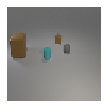

In [12]:
image_batch = next(iter(train_ds))
show_batch(image_batch.numpy())

In [17]:
import tensorflow.keras as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D

In [64]:
class AdaIN(Model):
    def __init__(self, feat_dim, z_dim):
        super().__init__()
        self.z_proj = Dense(
            units=feat_dim * 2,
            input_shape=(z_dim,),
            activation='relu',
            use_bias=True,            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        
    def call(self, features, z):
        """
        Adaptive instance normalization component. Works with both 4D and 5D tensors
        :features: features to be normalized
        :scale: scaling factor. This would otherwise be calculated as the sigma from a "style" features in style transfer
        :bias: bias factor. This would otherwise be calculated as the mean from a "style" features in style transfer
        """
        scale, bias = tf.split(self.z_proj(z), 2, num=2, axis=1)
        mean, variance = tf.nn.moments(features, list(range(len(features.get_shape())))[1:-1],
                                       keepdims=True)  # Only consider spatial dimension
        sigma = tf.math.rsqrt(variance + 1e-8)
        normalized = (features - mean) * sigma
        scale_broadcast = tf.reshape(scale, tf.shape(mean))
        bias_broadcast = tf.reshape(bias, tf.shape(mean))
        normalized = scale_broadcast * normalized
        normalized += bias_broadcast
        return normalized

In [120]:
class ObjectGenerator(Model):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        
        self.lrelu = K.layers.LeakyReLU(alpha=0.2)
        
        self.w = tf.Variable(tf.random.normal((4, 4, 4, w_dim), stddev=0.02), trainable=True)
        self.adain0 = AdaIN(w_dim, z_dim)
        
        self.deconv1 = K.layers.Conv3DTranspose(
            filters=128,
            kernel_size=(3, 3, 3),
            strides=(2, 2, 2),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.adain1 = AdaIN(128, z_dim)
        
        self.deconv2 = K.layers.Conv3DTranspose(
            filters=64,
            kernel_size=(3, 3, 3),
            strides=(2, 2, 2),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.adain2 = AdaIN(64, z_dim)
        
        self.proj1 = K.layers.Conv3DTranspose(
            filters=64,
            kernel_size=(3, 3, 3),
            strides=(1, 1, 1),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.proj2 = K.layers.Conv3DTranspose(
            filters=64,
            kernel_size=(3, 3, 3),
            strides=(1, 1, 1),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        
    def call(self, z, view_in=None):
        '''
        w: (bsz, num_objs, height, width, depth, channels)
        z: (bsz, num_objs, z_dim)
        view_in: (bsz, num_objs, 6)
        '''
        # TODO: reshape all objects of all samples in the batch
        # everything is 1 object during development/debugging
        # w = tf.reshape(w, ...) # (bsz * num_objs, height, width, depth, channels)
        # z = tf.reshape(w, ...) # (bsz * num_objs, z_dim)
        # view_in = tf.reshape(w, ...) # (bsz * num_objs, 6)
        bsz, z_bg_dim = z.shape
        w = tf.repeat(tf.expand_dims(self.w, 0), bsz, axis=0, name='w')
        
        h0 = self.adain0(w, z)
        h0 = self.lrelu(h0)
        
        h1 = self.deconv1(h0)
        h1 = self.adain1(h1, z)
        h1 = self.lrelu(h1)
        
        h2 = self.deconv2(h1)
        h2 = self.adain2(h2, z)
        h2 = self.lrelu(h2)
        
        ## TODO 3d transform
        # 3d_transform
        ## 
        
        # TEMP replace learnable projection with
        # a transformation
        h2_proj1 = self.proj1(h2)
        h2_proj1 = self.lrelu(h2_proj1)
        
        h2_proj2 = self.proj2(h2_proj1)
        h2_proj2 = self.lrelu(h2_proj2)
        
        return h2_proj2

class Generator(Model):
    def __init__(self, z_dim_bg=30, z_dim_fg=90):
        super().__init__()
        
        self.z_dim_bg = z_dim_bg
        self.z_dim_fg = z_dim_fg
        # self.lrelu = K.layers.LeakyReLU(alpha=0.2)
        
        self.lrelu = K.layers.LeakyReLU(alpha=0.2)
        self.bg_generator = ObjectGenerator(z_dim_bg, 256)
        self.fg_generator = ObjectGenerator(z_dim_fg, 512)
        
        self.deconv3 = K.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(1, 1),
            strides=(1, 1),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.deconv4 = K.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.deconv5 = K.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.deconv6 = K.layers.Conv2DTranspose(
            filters=3,
            kernel_size=(4, 4),
            strides=(1, 1),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        #self.deconv7 = K.layers.Conv2DTranspose(
        #    filters=3,
        #    kernel_size=(4, 4),
        #    strides=(1, 1),
        #    padding='same',
        #    kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
        #    bias_initializer='zeros',
        #)
        
    def call(self, bsz, z_bg=None, z_fg=None):
        # bsz, z_bg_dim = z_bg.shape
        z_bg = tf.ones((bsz, self.z_dim_bg), dtype=tf.float32)
        z_fg = tf.ones((bsz, self.z_dim_fg), dtype=tf.float32)
        
        bg = self.bg_generator(z_bg, None)
        fg = self.fg_generator(z_fg, None)
        
        bg = tf.expand_dims(bg, 1)
        fg = tf.expand_dims(fg, 1)
        
        composed_scene = tf.concat((bg, fg), axis=1)
        composed_scene = tf.math.reduce_max(composed_scene, axis=1, name='composed_scene')
        
        h2_2d = tf.reshape(composed_scene, (bsz, 16, 16, 16 * 64))
        
        h3 = self.lrelu(self.deconv3(h2_2d))
        h4 = self.lrelu(self.deconv4(h3))
        h5 = self.lrelu(self.deconv5(h4))
        h6 = tf.math.sigmoid(self.deconv6(h5))
        # h6 = self.lrelu(self.deconv6(h5))
        # h7 = tf.math.sigmoid(self.deconv7(h6))
        
        return h6

In [155]:
from tensorflow.keras.constraints import Constraint
POWER_ITERATIONS = 1


def l2_normalize(x, eps=1e-12):
    '''
  Scale input by the inverse of it's euclidean norm
  '''
    return x / tf.linalg.norm(x + eps)


class Spectral_Norm(Constraint):
    '''
    Uses power iteration method to calculate a fast approximation 
    of the spectral norm (Golub & Van der Vorst)
    The weights are then scaled by the inverse of the spectral norm
    '''
    def __init__(self, power_iters=POWER_ITERATIONS):
        self.n_iters = power_iters

    def __call__(self, w):
        flattened_w = tf.reshape(w, [w.shape[0], -1])
        u = tf.random.normal([flattened_w.shape[0]])
        v = tf.random.normal([flattened_w.shape[1]])
        for i in range(self.n_iters):
            v = tf.linalg.matvec(tf.transpose(flattened_w), u)
            v = l2_normalize(v)
            u = tf.linalg.matvec(flattened_w, v)
            u = l2_normalize(u)
        sigma = tf.tensordot(u, tf.linalg.matvec(flattened_w, v), axes=1)
        return w / sigma

    def get_config(self):
        return {'n_iters': self.n_iters}

class InstanceNorm(Model):
    def __init__(self, num_channels):
        super().__init__()
        self.scale = tf.Variable(initial_value=tf.random.normal((num_channels,), 1.0, 0.02))
        self.offset = tf.Variable(initial_value=tf.zeros((num_channels,), dtype=tf.float32))
    
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        epsilon = 1e-5
        inv = tf.math.rsqrt(variance + epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset
    
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        
        self.lrelu = K.layers.LeakyReLU(alpha=0.2)
        
        self.conv0 = Conv2D(
            filters=64,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='SAME',
            kernel_initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            # kernel_constraint=Spectral_Norm(),
        )
        
        self.conv1 = Conv2D(
            filters=128,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='SAME',
            kernel_initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            kernel_constraint=Spectral_Norm(),
        )
        self.inst_norm1 = InstanceNorm(128)
        
        self.conv2 = Conv2D(
            filters=256,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='SAME',
            kernel_initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            kernel_constraint=Spectral_Norm(),
        )
        self.inst_norm2 = InstanceNorm(256)
        
        self.conv3 = Conv2D(
            filters=512,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='SAME',
            kernel_initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            kernel_constraint=Spectral_Norm(),
        )
        self.inst_norm3 = InstanceNorm(512)
        
        self.linear = Dense(1, kernel_constraint=Spectral_Norm())

    def call(self, x):
        
        x = self.lrelu(self.conv0(x))
        x = self.lrelu(self.inst_norm1(self.conv1(x)))
        x = self.lrelu(self.inst_norm2(self.conv2(x)))
        x = self.lrelu(self.inst_norm3(self.conv3(x)))
        
        return self.linear(tf.reshape(x, (-1, 4 * 4 * 512)))
        
discriminator = Discriminator()
_res = discriminator(tf.random.normal((2, 64, 64, 3)))
_res.shape

TensorShape([2, 1])

In [164]:
def discriminator_loss(real, generated):
    real_loss = bce(tf.ones_like(real), real)

    generated_loss = bce(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return bce(tf.ones_like(generated), generated)

In [170]:
# optimizer = K.optimizers.Adam()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# mse = K.losses.MeanSquaredError()
bce = K.losses.BinaryCrossentropy(from_logits=True)
generator = Generator()

In [125]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
num_steps = 1000
pbar = tqdm(range(num_steps), total=num_steps)

total_g_loss = 0.
total_d_loss = 0.

for it in pbar:
    
    with tf.GradientTape(persistent=True) as tape:
        generated = generator(1)
        
        d_fake_logits = discriminator(generated)
        d_real_logits = discriminator(image_batch)
        
        d_loss = discriminator_loss(d_real_logits, d_fake_logits)
        g_loss = generator_loss(d_fake_logits)
        
    g_variables = generator.trainable_variables
    d_variables = discriminator.trainable_variables

    g_gradients = tape.gradient(g_loss, g_variables)
    d_gradients = tape.gradient(d_loss, d_variables)

    generator_optimizer.apply_gradients(zip(g_gradients, g_variables))
    discriminator_optimizer.apply_gradients(zip(d_gradients, d_variables)) 
    
    total_g_loss += g_loss.numpy()
    total_d_loss += d_loss.numpy()
    
    pbar.set_postfix(g_loss=f'{g_loss.numpy():.4f} ({total_g_loss / (it + 1):.4f})',
                     d_loss=f'{d_loss.numpy():.4f} ({total_d_loss / (it + 1):.4f})')
    # break

In [157]:
d_logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.6935361]], dtype=float32)>

In [122]:
loss.numpy()

0.0071974434

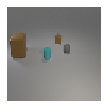

In [168]:
show_batch(image_batch)

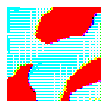

In [169]:
show_batch(generated)

In [92]:
image_batch.shape

TensorShape([1, 64, 64, 3])